# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

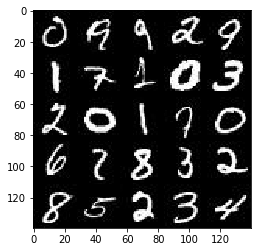

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

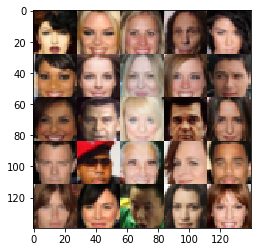

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

tf.reset_default_graph()
def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_tensor = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real')
    z = tf.placeholder(tf.float32, shape=(None, z_dim), name='input_z')
    learnrate = tf.placeholder(tf.float32, name='learning_rate')
    return input_tensor, z, learnrate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/carnd/anaconda3/envs/dl3/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/carnd/anaconda3/envs/dl3/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/carnd/anaconda3/envs/dl3/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>\n    app.launch_new_instance()', 'File "/home/carnd/anaconda3/envs/dl3/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/carnd/anaconda3/envs/dl3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start\n    ioloop.IOLoop.instance().start()', 'File "/home/carnd/anaconda3/env

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [33]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        x = tf.layers.conv2d(images, 128, (5, 5), strides=(2, 2), padding='same',
                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)
        # 14 x 14 x 128
        
        x = tf.layers.conv2d(x, 256, (5, 5), strides=(2, 2), padding='same',
                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)
        # 7 x 7 x 256
        
        x = tf.layers.conv2d(x, 512, (3, 3), strides=(2, 2), padding='same',
                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)
        # 3 x 3 x 512
        
        x = tf.contrib.layers.flatten(x)
        
        logits = tf.contrib.layers.fully_connected(x, 1, activation_fn=None)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [34]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x = tf.contrib.layers.fully_connected(z, 2 * 2 * 1024, activation_fn=None)
        
        # First layer
        x = tf.reshape(x, [-1, 2, 2, 1024])
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        # 2 x 2 x 1024
        
        # First transpose convolution
        x = tf.layers.conv2d_transpose(x, 512, (5, 5), strides=(2, 2), padding='valid',
                                      kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        # 7 x 7 x 512
        
        # Second transpose convolution
        x = tf.layers.conv2d_transpose(x, 256, (5, 5), strides=(2, 2), padding='same',
                                      kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        # 14 x 14 x 256
        
        # Output layer, 28x28xout_dim
        logits = x = tf.layers.conv2d_transpose(x, out_channel_dim, (5, 5), strides=(2, 2), padding='same',
                                               kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28 x 28 x 3
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [35]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [36]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [37]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [38]:
def scale(x):
    return 2 * x


def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    samples, losses = [], []
    steps = 0
    image_width, image_height = data_shape[1], data_shape[2]
    image_channels = data_shape[-1]
    
    input_real, input_z, learning_rate_ = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate_, beta1)
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # TODO: Train Model
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = scale(batch_images)
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_: learning_rate})
                
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, learning_rate_: learning_rate})

                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, data_shape[-1], data_image_mode)
        saver.save(sess, './checkpoints/generator.ckpt')
        
    return losses
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 5.0091... Generator Loss: 0.7842
Epoch 1/2... Discriminator Loss: 3.1378... Generator Loss: 0.0893
Epoch 1/2... Discriminator Loss: 2.4543... Generator Loss: 0.1212
Epoch 1/2... Discriminator Loss: 1.9654... Generator Loss: 4.4607
Epoch 1/2... Discriminator Loss: 0.2744... Generator Loss: 10.4844
Epoch 1/2... Discriminator Loss: 9.9883... Generator Loss: 19.0428
Epoch 1/2... Discriminator Loss: 2.8913... Generator Loss: 8.1886
Epoch 1/2... Discriminator Loss: 1.0290... Generator Loss: 3.2865
Epoch 1/2... Discriminator Loss: 1.8995... Generator Loss: 0.4490
Epoch 1/2... Discriminator Loss: 1.0774... Generator Loss: 3.6050


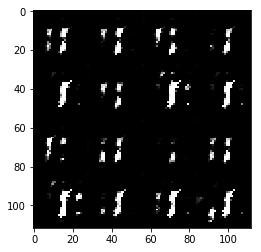

Epoch 1/2... Discriminator Loss: 1.8949... Generator Loss: 5.2842
Epoch 1/2... Discriminator Loss: 0.8968... Generator Loss: 0.8553
Epoch 1/2... Discriminator Loss: 1.0052... Generator Loss: 2.0961
Epoch 1/2... Discriminator Loss: 0.7978... Generator Loss: 1.2439
Epoch 1/2... Discriminator Loss: 2.5124... Generator Loss: 0.3799
Epoch 1/2... Discriminator Loss: 1.1792... Generator Loss: 1.6222
Epoch 1/2... Discriminator Loss: 1.3359... Generator Loss: 1.5982
Epoch 1/2... Discriminator Loss: 0.9106... Generator Loss: 0.7720
Epoch 1/2... Discriminator Loss: 1.9311... Generator Loss: 0.3089
Epoch 1/2... Discriminator Loss: 2.1910... Generator Loss: 5.0466


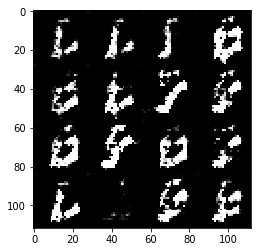

Epoch 1/2... Discriminator Loss: 1.5464... Generator Loss: 3.5217
Epoch 1/2... Discriminator Loss: 1.1891... Generator Loss: 1.2265
Epoch 1/2... Discriminator Loss: 2.2056... Generator Loss: 0.2350
Epoch 1/2... Discriminator Loss: 0.8263... Generator Loss: 1.6834
Epoch 1/2... Discriminator Loss: 0.7964... Generator Loss: 2.5500
Epoch 1/2... Discriminator Loss: 0.9625... Generator Loss: 0.8485
Epoch 1/2... Discriminator Loss: 1.6087... Generator Loss: 0.3666
Epoch 1/2... Discriminator Loss: 1.3651... Generator Loss: 0.4460
Epoch 1/2... Discriminator Loss: 1.8325... Generator Loss: 0.7238
Epoch 1/2... Discriminator Loss: 2.3830... Generator Loss: 0.5467


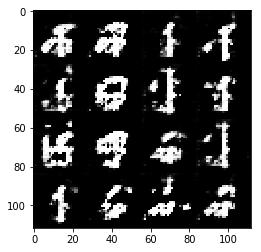

Epoch 1/2... Discriminator Loss: 1.5401... Generator Loss: 0.7238
Epoch 1/2... Discriminator Loss: 1.9066... Generator Loss: 0.2390
Epoch 1/2... Discriminator Loss: 1.7251... Generator Loss: 0.3572
Epoch 1/2... Discriminator Loss: 2.1849... Generator Loss: 0.2394
Epoch 1/2... Discriminator Loss: 1.3627... Generator Loss: 0.7720
Epoch 1/2... Discriminator Loss: 1.1287... Generator Loss: 1.4894
Epoch 1/2... Discriminator Loss: 1.8798... Generator Loss: 1.0675
Epoch 1/2... Discriminator Loss: 1.8787... Generator Loss: 1.3447
Epoch 1/2... Discriminator Loss: 1.8338... Generator Loss: 1.4711
Epoch 1/2... Discriminator Loss: 1.2467... Generator Loss: 1.0174


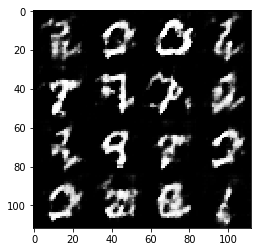

Epoch 1/2... Discriminator Loss: 1.7417... Generator Loss: 0.7882
Epoch 1/2... Discriminator Loss: 1.5726... Generator Loss: 0.9417
Epoch 1/2... Discriminator Loss: 1.7328... Generator Loss: 1.3512
Epoch 1/2... Discriminator Loss: 1.2218... Generator Loss: 1.5138
Epoch 1/2... Discriminator Loss: 1.8407... Generator Loss: 1.3666
Epoch 1/2... Discriminator Loss: 1.8455... Generator Loss: 0.7293
Epoch 2/2... Discriminator Loss: 1.3439... Generator Loss: 1.3295
Epoch 2/2... Discriminator Loss: 1.2437... Generator Loss: 1.5006
Epoch 2/2... Discriminator Loss: 2.1628... Generator Loss: 0.1888
Epoch 2/2... Discriminator Loss: 1.1881... Generator Loss: 0.8434


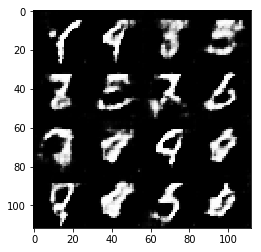

Epoch 2/2... Discriminator Loss: 1.5449... Generator Loss: 0.6651
Epoch 2/2... Discriminator Loss: 1.6684... Generator Loss: 0.3956
Epoch 2/2... Discriminator Loss: 1.5625... Generator Loss: 0.4024
Epoch 2/2... Discriminator Loss: 1.6629... Generator Loss: 0.3186
Epoch 2/2... Discriminator Loss: 1.4121... Generator Loss: 0.5114
Epoch 2/2... Discriminator Loss: 1.4095... Generator Loss: 0.6212
Epoch 2/2... Discriminator Loss: 1.8756... Generator Loss: 1.8235
Epoch 2/2... Discriminator Loss: 1.2545... Generator Loss: 1.1622
Epoch 2/2... Discriminator Loss: 1.4327... Generator Loss: 1.2469
Epoch 2/2... Discriminator Loss: 1.8368... Generator Loss: 1.5972


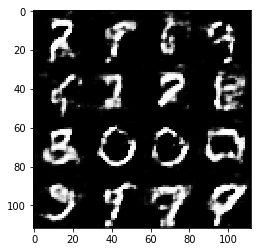

Epoch 2/2... Discriminator Loss: 1.6156... Generator Loss: 1.2815
Epoch 2/2... Discriminator Loss: 1.6538... Generator Loss: 1.3495
Epoch 2/2... Discriminator Loss: 1.3927... Generator Loss: 1.2720
Epoch 2/2... Discriminator Loss: 1.7306... Generator Loss: 1.3584
Epoch 2/2... Discriminator Loss: 1.6219... Generator Loss: 0.3438
Epoch 2/2... Discriminator Loss: 1.6526... Generator Loss: 1.3907
Epoch 2/2... Discriminator Loss: 1.4800... Generator Loss: 1.0803
Epoch 2/2... Discriminator Loss: 1.5601... Generator Loss: 1.4569
Epoch 2/2... Discriminator Loss: 1.6620... Generator Loss: 1.1370
Epoch 2/2... Discriminator Loss: 1.4560... Generator Loss: 1.3498


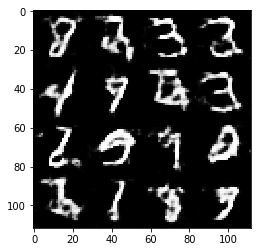

Epoch 2/2... Discriminator Loss: 1.6326... Generator Loss: 1.1634
Epoch 2/2... Discriminator Loss: 1.5688... Generator Loss: 1.2446
Epoch 2/2... Discriminator Loss: 1.5614... Generator Loss: 1.5655
Epoch 2/2... Discriminator Loss: 2.4712... Generator Loss: 2.3205
Epoch 2/2... Discriminator Loss: 1.6391... Generator Loss: 0.3255
Epoch 2/2... Discriminator Loss: 1.5047... Generator Loss: 0.3714
Epoch 2/2... Discriminator Loss: 1.8208... Generator Loss: 0.2403
Epoch 2/2... Discriminator Loss: 1.4170... Generator Loss: 0.6115
Epoch 2/2... Discriminator Loss: 1.3029... Generator Loss: 0.9316
Epoch 2/2... Discriminator Loss: 1.3569... Generator Loss: 0.7396


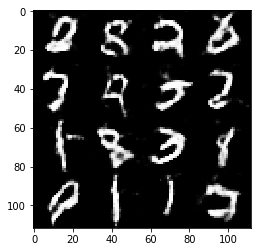

Epoch 2/2... Discriminator Loss: 1.4239... Generator Loss: 0.8983
Epoch 2/2... Discriminator Loss: 1.3252... Generator Loss: 0.7056
Epoch 2/2... Discriminator Loss: 1.3363... Generator Loss: 0.5462
Epoch 2/2... Discriminator Loss: 1.3070... Generator Loss: 0.7704
Epoch 2/2... Discriminator Loss: 1.4121... Generator Loss: 0.5278
Epoch 2/2... Discriminator Loss: 1.4859... Generator Loss: 0.3991
Epoch 2/2... Discriminator Loss: 1.4851... Generator Loss: 0.7682
Epoch 2/2... Discriminator Loss: 1.6601... Generator Loss: 0.3112
Epoch 2/2... Discriminator Loss: 1.9689... Generator Loss: 0.1843
Epoch 2/2... Discriminator Loss: 1.3709... Generator Loss: 0.6895


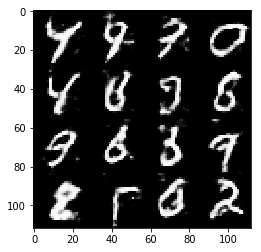

Epoch 2/2... Discriminator Loss: 1.3810... Generator Loss: 0.8467
Epoch 2/2... Discriminator Loss: 1.4378... Generator Loss: 1.1284
Epoch 2/2... Discriminator Loss: 1.6576... Generator Loss: 1.4918


In [39]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.8817... Generator Loss: 0.4284
Epoch 1/1... Discriminator Loss: 0.8891... Generator Loss: 2.3975
Epoch 1/1... Discriminator Loss: 0.9259... Generator Loss: 1.4207
Epoch 1/1... Discriminator Loss: 0.5652... Generator Loss: 4.0283
Epoch 1/1... Discriminator Loss: 0.5797... Generator Loss: 5.8884
Epoch 1/1... Discriminator Loss: 0.9331... Generator Loss: 1.0473
Epoch 1/1... Discriminator Loss: 1.5992... Generator Loss: 0.7758
Epoch 1/1... Discriminator Loss: 1.9734... Generator Loss: 0.2590
Epoch 1/1... Discriminator Loss: 1.0287... Generator Loss: 1.7216
Epoch 1/1... Discriminator Loss: 1.1807... Generator Loss: 1.4202


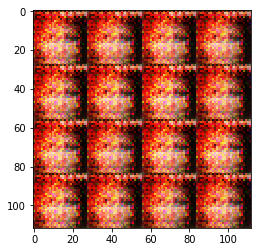

Epoch 1/1... Discriminator Loss: 0.7106... Generator Loss: 2.0885
Epoch 1/1... Discriminator Loss: 0.8253... Generator Loss: 1.9449
Epoch 1/1... Discriminator Loss: 0.6995... Generator Loss: 2.0706
Epoch 1/1... Discriminator Loss: 0.6842... Generator Loss: 2.2805
Epoch 1/1... Discriminator Loss: 1.8714... Generator Loss: 2.1784
Epoch 1/1... Discriminator Loss: 1.1530... Generator Loss: 1.1692
Epoch 1/1... Discriminator Loss: 2.6626... Generator Loss: 0.4537
Epoch 1/1... Discriminator Loss: 1.7855... Generator Loss: 0.6154
Epoch 1/1... Discriminator Loss: 1.7301... Generator Loss: 0.5824
Epoch 1/1... Discriminator Loss: 2.5492... Generator Loss: 0.6129


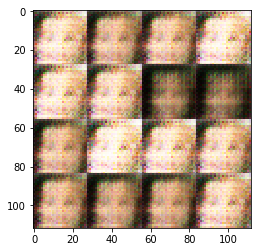

Epoch 1/1... Discriminator Loss: 2.0261... Generator Loss: 0.6117
Epoch 1/1... Discriminator Loss: 1.4510... Generator Loss: 0.8110
Epoch 1/1... Discriminator Loss: 2.2130... Generator Loss: 0.2521
Epoch 1/1... Discriminator Loss: 2.0146... Generator Loss: 0.5908
Epoch 1/1... Discriminator Loss: 1.3555... Generator Loss: 0.7970
Epoch 1/1... Discriminator Loss: 0.9347... Generator Loss: 1.1151
Epoch 1/1... Discriminator Loss: 1.6898... Generator Loss: 0.7298
Epoch 1/1... Discriminator Loss: 1.3359... Generator Loss: 0.8863
Epoch 1/1... Discriminator Loss: 1.4872... Generator Loss: 0.7006
Epoch 1/1... Discriminator Loss: 1.8208... Generator Loss: 0.5062


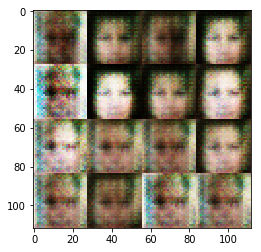

Epoch 1/1... Discriminator Loss: 1.7637... Generator Loss: 0.5555
Epoch 1/1... Discriminator Loss: 1.7192... Generator Loss: 0.6326
Epoch 1/1... Discriminator Loss: 1.7096... Generator Loss: 0.5740
Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 0.8690
Epoch 1/1... Discriminator Loss: 1.5864... Generator Loss: 0.6305
Epoch 1/1... Discriminator Loss: 1.5883... Generator Loss: 0.8977
Epoch 1/1... Discriminator Loss: 1.6013... Generator Loss: 0.6036
Epoch 1/1... Discriminator Loss: 1.7823... Generator Loss: 0.6544
Epoch 1/1... Discriminator Loss: 1.7798... Generator Loss: 0.7016
Epoch 1/1... Discriminator Loss: 1.5657... Generator Loss: 0.7520


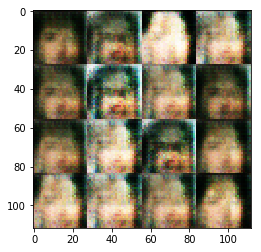

Epoch 1/1... Discriminator Loss: 1.5860... Generator Loss: 0.6161
Epoch 1/1... Discriminator Loss: 1.6711... Generator Loss: 0.6701
Epoch 1/1... Discriminator Loss: 1.6860... Generator Loss: 0.6530
Epoch 1/1... Discriminator Loss: 1.4372... Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 1.6058... Generator Loss: 0.6757
Epoch 1/1... Discriminator Loss: 1.6283... Generator Loss: 0.5543
Epoch 1/1... Discriminator Loss: 1.6884... Generator Loss: 0.5605
Epoch 1/1... Discriminator Loss: 1.6157... Generator Loss: 0.6295
Epoch 1/1... Discriminator Loss: 1.5547... Generator Loss: 0.6681
Epoch 1/1... Discriminator Loss: 1.3579... Generator Loss: 0.7466


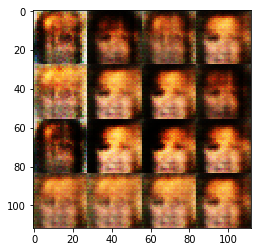

Epoch 1/1... Discriminator Loss: 1.6036... Generator Loss: 0.6243
Epoch 1/1... Discriminator Loss: 1.5493... Generator Loss: 0.6973
Epoch 1/1... Discriminator Loss: 1.5375... Generator Loss: 0.7011
Epoch 1/1... Discriminator Loss: 1.4934... Generator Loss: 0.6436
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.7111
Epoch 1/1... Discriminator Loss: 1.5712... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 1.5077... Generator Loss: 0.6689
Epoch 1/1... Discriminator Loss: 1.8014... Generator Loss: 0.5776
Epoch 1/1... Discriminator Loss: 1.6744... Generator Loss: 0.6578
Epoch 1/1... Discriminator Loss: 1.4653... Generator Loss: 0.7157


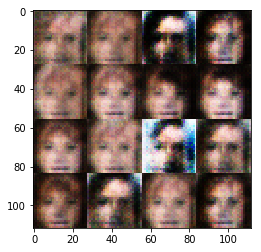

Epoch 1/1... Discriminator Loss: 1.2625... Generator Loss: 0.8315
Epoch 1/1... Discriminator Loss: 1.5419... Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 1.4548... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 1.5130... Generator Loss: 0.6143
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.7261
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.6984
Epoch 1/1... Discriminator Loss: 1.7216... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.6255... Generator Loss: 0.6064
Epoch 1/1... Discriminator Loss: 1.5270... Generator Loss: 0.7609
Epoch 1/1... Discriminator Loss: 1.3465... Generator Loss: 0.7127


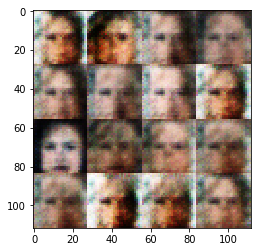

Epoch 1/1... Discriminator Loss: 1.5197... Generator Loss: 0.6587
Epoch 1/1... Discriminator Loss: 1.6823... Generator Loss: 0.6418
Epoch 1/1... Discriminator Loss: 1.5461... Generator Loss: 0.6916
Epoch 1/1... Discriminator Loss: 1.4966... Generator Loss: 0.6416
Epoch 1/1... Discriminator Loss: 1.4924... Generator Loss: 0.7068
Epoch 1/1... Discriminator Loss: 1.4862... Generator Loss: 0.7110
Epoch 1/1... Discriminator Loss: 1.6623... Generator Loss: 0.6021
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.6913
Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.7428


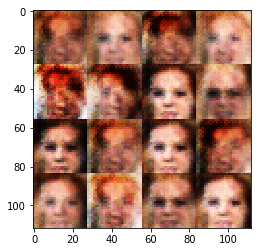

Epoch 1/1... Discriminator Loss: 1.5733... Generator Loss: 0.6269
Epoch 1/1... Discriminator Loss: 1.5643... Generator Loss: 0.6042
Epoch 1/1... Discriminator Loss: 1.4784... Generator Loss: 0.7179
Epoch 1/1... Discriminator Loss: 1.4983... Generator Loss: 0.6653
Epoch 1/1... Discriminator Loss: 1.4889... Generator Loss: 0.6367
Epoch 1/1... Discriminator Loss: 1.4859... Generator Loss: 0.6837
Epoch 1/1... Discriminator Loss: 1.5043... Generator Loss: 0.6231
Epoch 1/1... Discriminator Loss: 1.5847... Generator Loss: 0.5797
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.7395
Epoch 1/1... Discriminator Loss: 1.4895... Generator Loss: 0.6434


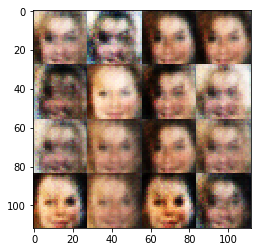

Epoch 1/1... Discriminator Loss: 1.4399... Generator Loss: 0.6725
Epoch 1/1... Discriminator Loss: 1.2806... Generator Loss: 0.8295
Epoch 1/1... Discriminator Loss: 1.6105... Generator Loss: 0.5993
Epoch 1/1... Discriminator Loss: 1.6071... Generator Loss: 0.5429
Epoch 1/1... Discriminator Loss: 1.3227... Generator Loss: 0.7275
Epoch 1/1... Discriminator Loss: 1.5858... Generator Loss: 0.6441
Epoch 1/1... Discriminator Loss: 1.6556... Generator Loss: 0.6140
Epoch 1/1... Discriminator Loss: 1.6134... Generator Loss: 0.6640
Epoch 1/1... Discriminator Loss: 1.5037... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 1.3100... Generator Loss: 0.7597


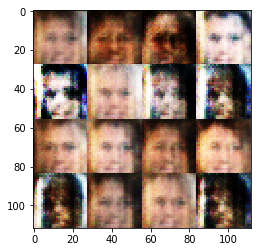

Epoch 1/1... Discriminator Loss: 1.3295... Generator Loss: 0.7486
Epoch 1/1... Discriminator Loss: 1.5681... Generator Loss: 0.6076
Epoch 1/1... Discriminator Loss: 1.6086... Generator Loss: 0.6591
Epoch 1/1... Discriminator Loss: 1.5014... Generator Loss: 0.6108
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.7959
Epoch 1/1... Discriminator Loss: 1.4763... Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 1.5041... Generator Loss: 0.6789
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.7367
Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.6563


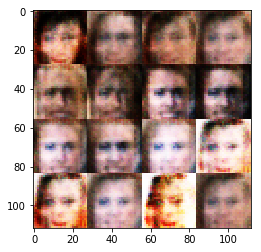

Epoch 1/1... Discriminator Loss: 1.6379... Generator Loss: 0.5979
Epoch 1/1... Discriminator Loss: 1.6449... Generator Loss: 0.6024
Epoch 1/1... Discriminator Loss: 1.5626... Generator Loss: 0.7167
Epoch 1/1... Discriminator Loss: 1.5462... Generator Loss: 0.6192
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.7576
Epoch 1/1... Discriminator Loss: 1.3504... Generator Loss: 0.7489
Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 0.7174
Epoch 1/1... Discriminator Loss: 1.4930... Generator Loss: 0.6293
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.7686
Epoch 1/1... Discriminator Loss: 1.4504... Generator Loss: 0.6176


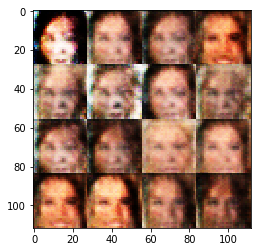

Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 0.7585
Epoch 1/1... Discriminator Loss: 1.5564... Generator Loss: 0.6365
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.6724
Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.6841
Epoch 1/1... Discriminator Loss: 1.4154... Generator Loss: 0.7392
Epoch 1/1... Discriminator Loss: 1.4440... Generator Loss: 0.7186
Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.6854
Epoch 1/1... Discriminator Loss: 1.5321... Generator Loss: 0.6381
Epoch 1/1... Discriminator Loss: 1.4665... Generator Loss: 0.6739
Epoch 1/1... Discriminator Loss: 1.5493... Generator Loss: 0.5780


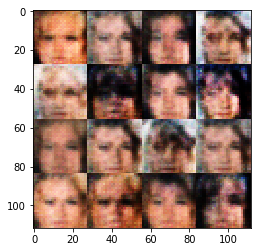

Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.7404
Epoch 1/1... Discriminator Loss: 1.4424... Generator Loss: 0.7223
Epoch 1/1... Discriminator Loss: 1.5304... Generator Loss: 0.6076
Epoch 1/1... Discriminator Loss: 1.5077... Generator Loss: 0.6484
Epoch 1/1... Discriminator Loss: 1.5415... Generator Loss: 0.5831
Epoch 1/1... Discriminator Loss: 1.4895... Generator Loss: 0.5696
Epoch 1/1... Discriminator Loss: 1.3644... Generator Loss: 0.7747
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.7434
Epoch 1/1... Discriminator Loss: 1.3136... Generator Loss: 0.8638
Epoch 1/1... Discriminator Loss: 1.3486... Generator Loss: 0.7296


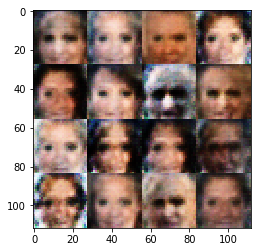

Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.6877
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.6220
Epoch 1/1... Discriminator Loss: 1.4275... Generator Loss: 0.7551
Epoch 1/1... Discriminator Loss: 1.5243... Generator Loss: 0.6440
Epoch 1/1... Discriminator Loss: 1.4841... Generator Loss: 0.6636
Epoch 1/1... Discriminator Loss: 1.5120... Generator Loss: 0.6364
Epoch 1/1... Discriminator Loss: 1.5084... Generator Loss: 0.7599
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.7287
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.7213
Epoch 1/1... Discriminator Loss: 1.4602... Generator Loss: 0.7002


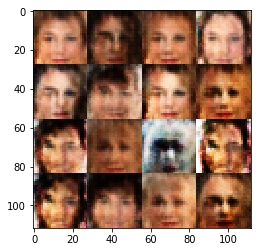

Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.7245
Epoch 1/1... Discriminator Loss: 1.4279... Generator Loss: 0.7127
Epoch 1/1... Discriminator Loss: 1.5280... Generator Loss: 0.7135
Epoch 1/1... Discriminator Loss: 1.6552... Generator Loss: 0.5432
Epoch 1/1... Discriminator Loss: 1.4894... Generator Loss: 0.7187
Epoch 1/1... Discriminator Loss: 1.4896... Generator Loss: 0.6184
Epoch 1/1... Discriminator Loss: 1.4655... Generator Loss: 0.7339
Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 0.7432


In [40]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.